##### Importing required Libraries

In [14]:
import requests
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
%matplotlib inline

##### Getting all the expiries date to get the data of NIFTY index.

In [15]:
end_date_api = "https://live.markethound.in/api/history/expiries?index=NIFTY"
response = requests.get(end_date_api)

if response.status_code == 200:
    expiry_json = response.json()
    expiry_data = expiry_json['result']
else:
    print("Error:", response.status_code)

##### Getting the NIFTY data in a pandas dataframe

In [16]:
data = []
for x in expiry_data:
    api_url = "https://live.markethound.in/api/history/dtelist?index=NIFTY&expiry="
    api_url += x
    response1 = requests.get(api_url)

    if response1.status_code == 200:
        json_data = response1.json()
        temp_data = json_data['result']
        data.append(temp_data)
    else:
        print("Error:", response.status_code)
complete_data = [item for sublist in data for item in sublist]
df = pd.DataFrame(complete_data)

# Removed unncessary columns, overnightExpected is an expected value and not a actual one so it is not a good feature 
# to train the model on, also converted the expiry and date column in pandas datetime format.
columns_to_remove = ['_id','index','overnightExpected']
df = df.drop(columns=columns_to_remove, axis=1)
df[['expiry','date']] = df[['expiry', 'date']].apply(lambda x: pd.to_datetime(x).dt.date)
df = df.apply(pd.to_numeric, errors='ignore')

# Arranged all the columns in this order as it will be easier to analyze.
desired_col_order = ['expiry','date','daysToExpiry','index_open','index_close','index_high','index_low','intradayMovement','intradayTotal','overnightGap','open','close','high','low']
df = df[desired_col_order]

# In the orginal data taken from the APIs there were many duplicate datas that were present in multiple APIs, so removing
# them after sorting according to dte so that for each of the expiry date dte 0 to 4 data will be preserved.
df.sort_values(by='daysToExpiry', inplace=True)
df_unique = df.drop_duplicates(subset='date', keep='first')
df_unique = df_unique.sort_values(by='date', ascending=False)
df_unique.reset_index(drop=True, inplace=True)
df_unique

,expiry,date,daysToExpiry,index_open,index_close,index_high,index_low,intradayMovement,intradayTotal,overnightGap,open,close,high,low
0,2024-03-14,2024-03-14,0,21956.00,22144.95,22201.90,21928.65,273.25,141.20,0.00,144.60,3.40,156.80,2.70
1,2024-03-14,2024-03-13,1,22403.05,21984.20,22411.65,21909.55,502.10,36.30,28.20,187.65,151.35,224.55,151.35
2,2024-03-14,2024-03-12,2,22341.65,22335.65,22450.70,22261.40,189.30,22.15,-67.40,220.70,198.55,233.15,195.25
3,2024-03-14,2024-03-11,3,22486.95,22325.40,22511.00,22311.20,199.80,30.30,-16.25,260.85,230.55,260.85,230.55
4,2024-03-07,2024-03-07,0,22498.05,22483.60,22519.60,22439.20,80.40,111.45,0.00,118.00,6.55,118.00,4.65
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,2023-07-27,2023-07-24,3,19729.35,19663.65,19781.45,19663.65,117.80,39.15,-34.10,212.20,173.05,212.20,173.05
160,2023-07-27,2023-07-21,4,19797.10,19772.00,19885.90,19709.10,176.80,13.20,42.65,229.00,215.80,237.80,211.45
161,2023-07-20,2023-07-20,0,19831.10,19967.70,19989.90,19759.65,230.25,74.90,0.00,95.00,20.10,95.10,15.80
162,2023-07-20,2023-07-19,1,19837.75,19839.55,19841.60,19730.65,110.95,32.25,8.45,126.90,94.65,127.50,94.30


#### Building a ML model which assumes that today's price depends only on the previous 4 days prices

In [17]:
X = 4

# Shifing the open, close, low, high data by 1 to 4 and creating a new column for it for training
for i in range(1, X+1):
    for col in ['open', 'low', 'close', 'high']:
        df_unique[f'{col}_lag_{i}'] = df_unique[col].shift(-i)
for col in ['index_open','index_close','index_high','index_low','intradayMovement','intradayTotal','overnightGap']:
    df_unique[f'{col}'] = df_unique[col].shift(-1)
df_unique.dropna(inplace=True)
df_unique

,expiry,date,daysToExpiry,index_open,index_close,index_high,index_low,intradayMovement,intradayTotal,overnightGap,...,close_lag_2,high_lag_2,open_lag_3,low_lag_3,close_lag_3,high_lag_3,open_lag_4,low_lag_4,close_lag_4,high_lag_4
0,2024-03-14,2024-03-14,0,22403.05,21984.20,22411.65,21909.55,502.1,36.30,28.20,...,198.55,233.15,260.85,230.55,230.55,260.85,118.00,4.65,6.55,118.00
1,2024-03-14,2024-03-13,1,22341.65,22335.65,22450.70,22261.40,189.3,22.15,-67.40,...,230.55,260.85,118.00,4.65,6.55,118.00,185.35,123.10,125.55,190.60
2,2024-03-14,2024-03-12,2,22486.95,22325.40,22511.00,22311.20,199.8,30.30,-16.25,...,6.55,118.00,185.35,123.10,125.55,190.60,237.55,183.40,183.40,237.55
3,2024-03-14,2024-03-11,3,22498.05,22483.60,22519.60,22439.20,80.4,111.45,0.00,...,125.55,190.60,237.55,183.40,183.40,237.55,279.10,241.60,244.20,282.55
4,2024-03-07,2024-03-07,0,22304.55,22484.55,22486.55,22227.55,259.0,59.80,-13.50,...,183.40,237.55,279.10,241.60,244.20,282.55,324.10,304.25,304.25,340.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,2023-08-03,2023-07-28,4,19835.05,19699.75,19865.60,19605.80,259.8,83.60,0.00,...,113.25,134.30,170.65,134.25,136.00,170.65,212.20,173.05,173.05,212.20
156,2023-07-27,2023-07-27,0,19737.75,19771.65,19823.75,19720.95,102.8,21.05,-63.40,...,136.00,170.65,212.20,173.05,173.05,212.20,229.00,211.45,215.80,237.80
157,2023-07-27,2023-07-26,1,19697.75,19681.05,19706.25,19621.85,84.4,34.65,-56.70,...,173.05,212.20,229.00,211.45,215.80,237.80,95.00,15.80,20.10,95.10
158,2023-07-27,2023-07-25,2,19729.35,19663.65,19781.45,19663.65,117.8,39.15,-34.10,...,215.80,237.80,95.00,15.80,20.10,95.10,126.90,94.30,94.65,127.50


##### Obtaining the necessary columns for training

In [18]:
lagged_features = []
for i in range(1, X + 1):
    for col in ['open', 'low', 'close', 'high']:
        lagged_features.append(f'{col}_lag_{i}')
    lagged_features.append('index_open')
    lagged_features.append('index_low')
    lagged_features.append('index_close')
    lagged_features.append('index_high')
    lagged_features.append('intradayMovement')
    lagged_features.append('intradayTotal')
    lagged_features.append('overnightGap')
X_data = pd.concat([df_unique[[feature]] for feature in lagged_features], axis=1)
y = df_unique[['open', 'low', 'close', 'high']]
X_data

,open_lag_1,low_lag_1,close_lag_1,high_lag_1,index_open,index_low,index_close,index_high,intradayMovement,intradayTotal,...,low_lag_4,close_lag_4,high_lag_4,index_open,index_low,index_close,index_high,intradayMovement,intradayTotal,overnightGap
0,187.65,151.35,151.35,224.55,22403.05,21909.55,21984.20,22411.65,502.1,36.30,...,4.65,6.55,118.00,22403.05,21909.55,21984.20,22411.65,502.1,36.30,28.20
1,220.70,195.25,198.55,233.15,22341.65,22261.40,22335.65,22450.70,189.3,22.15,...,123.10,125.55,190.60,22341.65,22261.40,22335.65,22450.70,189.3,22.15,-67.40
2,260.85,230.55,230.55,260.85,22486.95,22311.20,22325.40,22511.00,199.8,30.30,...,183.40,183.40,237.55,22486.95,22311.20,22325.40,22511.00,199.8,30.30,-16.25
3,118.00,4.65,6.55,118.00,22498.05,22439.20,22483.60,22519.60,80.4,111.45,...,241.60,244.20,282.55,22498.05,22439.20,22483.60,22519.60,80.4,111.45,0.00
4,185.35,123.10,125.55,190.60,22304.55,22227.55,22484.55,22486.55,259.0,59.80,...,304.25,304.25,340.25,22304.55,22227.55,22484.55,22486.55,259.0,59.80,-13.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,93.25,6.15,9.65,93.25,19835.05,19605.80,19699.75,19865.60,259.8,83.60,...,173.05,173.05,212.20,19835.05,19605.80,19699.75,19865.60,259.8,83.60,0.00
156,134.30,108.75,113.25,134.30,19737.75,19720.95,19771.65,19823.75,102.8,21.05,...,211.45,215.80,237.80,19737.75,19720.95,19771.65,19823.75,102.8,21.05,-63.40
157,170.65,134.25,136.00,170.65,19697.75,19621.85,19681.05,19706.25,84.4,34.65,...,15.80,20.10,95.10,19697.75,19621.85,19681.05,19706.25,84.4,34.65,-56.70
158,212.20,173.05,173.05,212.20,19729.35,19663.65,19663.65,19781.45,117.8,39.15,...,94.30,94.65,127.50,19729.35,19663.65,19663.65,19781.45,117.8,39.15,-34.10


##### Building a LSTM model

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)
np.random.seed(42)

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scalers = MinMaxScaler()
y_train_scaled = scalers.fit_transform(y_train)
y_test_scaled = scalers.transform(y_test)

# Reshaping the training data to make it a tensor
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X, 11))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], X, 11))

# USED BELOW FOR LOOP TO GET OPTIMAL EPOCHS TO BE 45!

# Error = []
# Epochs = []
# for i in range(10,80,5):
#     model = Sequential()
#     model.add(LSTM(65, activation='relu', input_shape=(X, 11)))
#     model.add(Dense(4))  # Output layer with 1 neurons for predicting open,low,close,high
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(X_train_reshaped, y_train_scaled, epochs=i, batch_size=16, validation_data=(X_test_reshaped, y_test_scaled))
#     mse = model.evaluate(X_test_reshaped, y_test_scaled)
#     Error.append(mse)
#     Epochs.append(i)
# plt.plot(Epochs, Error, label = 'epoch error')
# plt.legend()
# plt.show

# USED BELOW FOR LOOP TO GET BATCH_SIZE TO BE 8!

# Error = []
# Batch_size = []
# for i in range(8,80,8):
#     model = Sequential()
#     model.add(LSTM(65, activation='relu', input_shape=(X, 11)))
#     model.add(Dense(4))  # Output layer with 1 neurons for predicting open,low,close,high
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(X_train_reshaped, y_train_scaled, epochs=15, batch_size=i, validation_data=(X_test_reshaped, y_test_scaled))
#     mse = model.evaluate(X_test_reshaped, y_test_scaled)
#     Error.append(mse)
#     Batch_size.append(i)
# plt.plot(Batch_size, Error, label = 'epoch error')
# plt.legend()
# plt.show

model = Sequential()
model.add(LSTM(65, activation='relu', input_shape=(X, 11)))
model.add(Dense(4))  # Output layer with 1 neurons for predicting open,low,close,high
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train_reshaped, y_train_scaled, epochs=45, batch_size=8, validation_data=(X_test_reshaped, y_test_scaled))
mse = model.evaluate(X_test_reshaped, y_test_scaled)
print("Mean Squared Error:", mse)

Epoch 1/45
16/16 [==============================] - 1s 17ms/step - loss: 0.1444 - val_loss: 0.0869
Epoch 2/45
16/16 [==============================] - 0s 5ms/step - loss: 0.0496 - val_loss: 0.0703
Epoch 3/45
16/16 [==============================] - 0s 6ms/step - loss: 0.0477 - val_loss: 0.0630
Epoch 4/45
16/16 [==============================] - 0s 5ms/step - loss: 0.0465 - val_loss: 0.0584
Epoch 5/45
16/16 [==============================] - 0s 5ms/step - loss: 0.0440 - val_loss: 0.0549
Epoch 6/45
16/16 [==============================] - 0s 5ms/step - loss: 0.0425 - val_loss: 0.0511
Epoch 7/45
16/16 [==============================] - 0s 4ms/step - loss: 0.0411 - val_loss: 0.0486
Epoch 8/45
16/16 [==============================] - 0s 5ms/step - loss: 0.0367 - val_loss: 0.0418
Epoch 9/45
16/16 [==============================] - 0s 5ms/step - loss: 0.0331 - val_loss: 0.0345
Epoch 10/45
16/16 [==============================] - 0s 4ms/step - loss: 0.0277 - val_loss: 0.0293
Epoch 11/45
16/16 

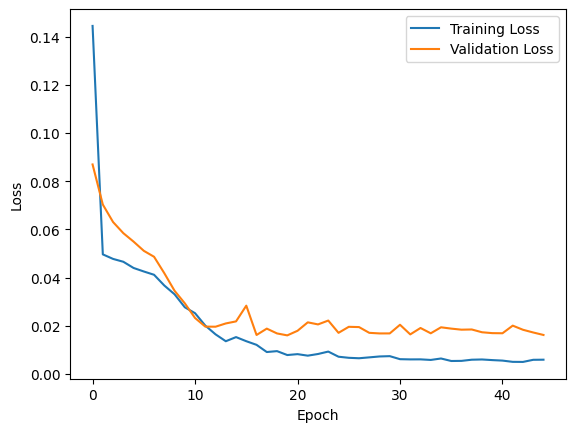

In [20]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [21]:
predictions = model.predict(X_test_reshaped)
predictions = scalers.inverse_transform(predictions)

1/1 [==============================] - 0s 155ms/step


##### Predicted open v/s Actual open

<function matplotlib.pyplot.show(close=None, block=None)>

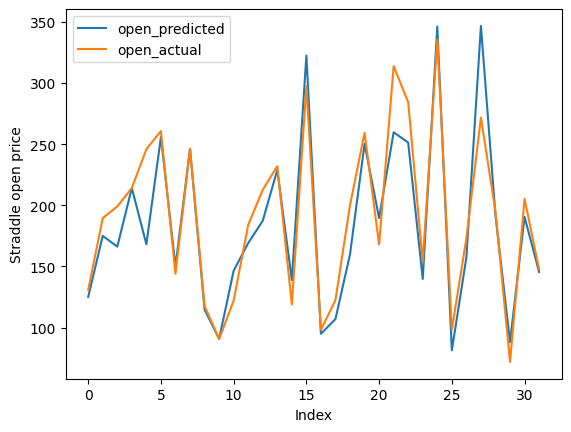

In [22]:
idx = np.arange(predictions.shape[0])
plt.plot(idx, predictions[:,0], label = 'open_predicted')
plt.plot(idx, y_test.iloc[:,0], label = 'open_actual')
plt.xlabel('Index')
plt.ylabel('Straddle open price')
plt.legend()
plt.show

##### Predicted low v/s Actual low

<function matplotlib.pyplot.show(close=None, block=None)>

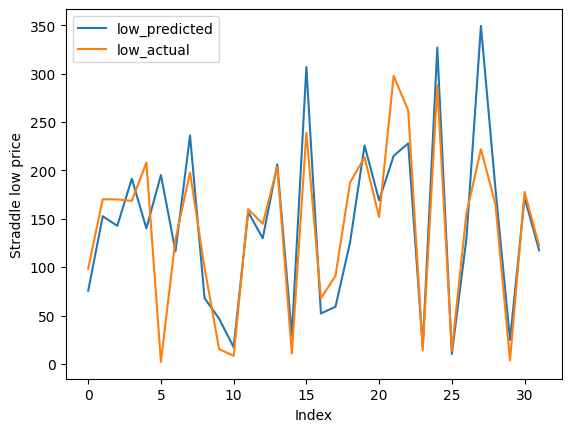

In [23]:
plt.plot(idx, predictions[:,1], label = 'low_predicted')
plt.plot(idx, y_test.iloc[:,1], label = 'low_actual')
plt.xlabel('Index')
plt.ylabel('Straddle low price')
plt.legend()
plt.show

##### Predicted close v/s Actual close

<function matplotlib.pyplot.show(close=None, block=None)>

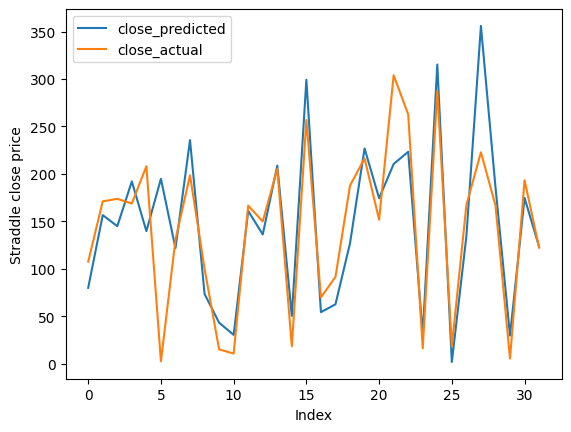

In [24]:
plt.plot(idx, predictions[:,2], label = 'close_predicted')
plt.plot(idx, y_test.iloc[:,2], label = 'close_actual')
plt.xlabel('Index')
plt.ylabel('Straddle close price')
plt.legend()
plt.show

##### Predicted high v/s Actual high

<function matplotlib.pyplot.show(close=None, block=None)>

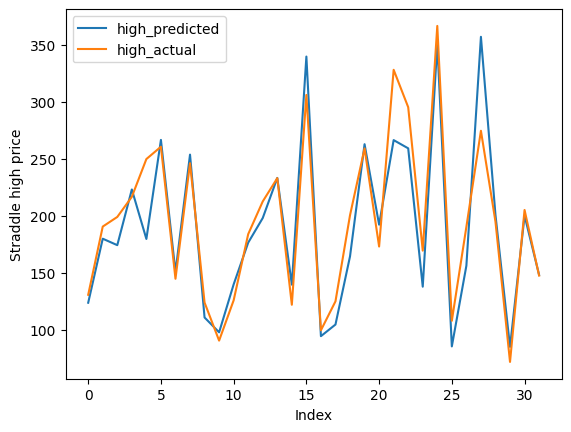

In [25]:
plt.plot(idx, predictions[:,3], label = 'high_predicted')
plt.plot(idx, y_test.iloc[:,3], label = 'high_actual')
plt.xlabel('Index')
plt.ylabel('Straddle high price')
plt.legend()
plt.show